# Importing the required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import os
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import plotly.express as px
import seaborn as sns
from tensorflow.keras.layers import Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.models import Model,Sequential
 
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D

# Creating a Data Processing batch

In [2]:
batch_size = 32
img_height = 150
img_width = 150

# Plotting the images

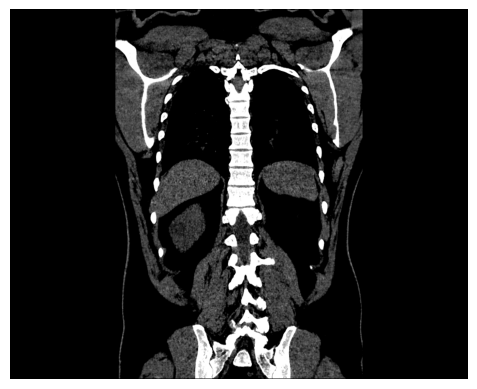

In [3]:
orig_img = cv2.imread(r"C:\Users\Desktop\MLIA\CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone\CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone\Cyst\Cyst- (30).jpg",1)
plt.imshow(cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

# Converting each image into grayscale to make sure that no image is a color image

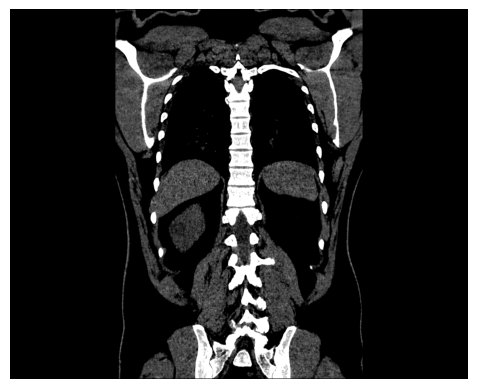

In [4]:
gray_img = cv2.cvtColor( orig_img, cv2.COLOR_BGR2GRAY ) 
plt.imshow(gray_img,cmap='gray')
plt.axis('off')
plt.show()

# Inputting the data and splitting the data into training and validation

In [5]:
data_dir=r"C:\Users\Desktop\MLIA\CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone\CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone"
train=tf.keras.utils.image_dataset_from_directory(data_dir,image_size=(img_height,img_width),
                                                validation_split=0.1,
                                                subset='training',seed=123)

val=tf.keras.utils.image_dataset_from_directory(data_dir,image_size=(img_height,img_width),
                                                validation_split=0.2,
                                                subset='validation',seed=123)

Found 12446 files belonging to 4 classes.
Using 11202 files for training.
Found 12446 files belonging to 4 classes.
Using 2489 files for validation.


# Plotting the frequencies of data in each class in the dataset

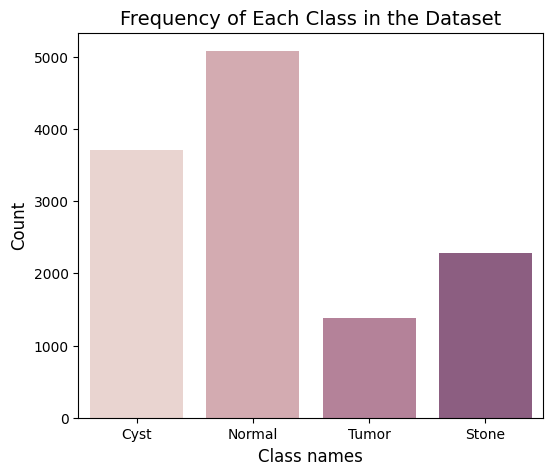

In [7]:
class_names = ['Cyst', 'Normal', 'Tumor', 'Stone'] 

cyst = len(os.listdir(r"C:\Users\MLIA\CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone\CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone\Cyst"))
normal = len(os.listdir(r"C:\Users\MLIA\CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone\CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone\Normal"))
stone = len(os.listdir(r"C:\Users\MLIA\CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone\CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone\Stone"))
tumor = len(os.listdir(r"C:\Users\Desktop\MLIA\CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone\CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone\Tumor"))

images = [cyst, normal, stone, tumor]
x
plt.figure(figsize=(6,5))
sns.barplot(x= class_names, y= images, palette= sns.cubehelix_palette())
plt.title('Frequency of Each Class in the Dataset', fontsize=14)
plt.xlabel('Class names', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(images)))
plt.show()
px.pie(names= class_names, values= images, color_discrete_sequence=px.colors.sequential.BuGn)

In [8]:
for image_batch, labels_batch in train:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 150, 150, 3)
(32,)


# Displaying images in the dataset

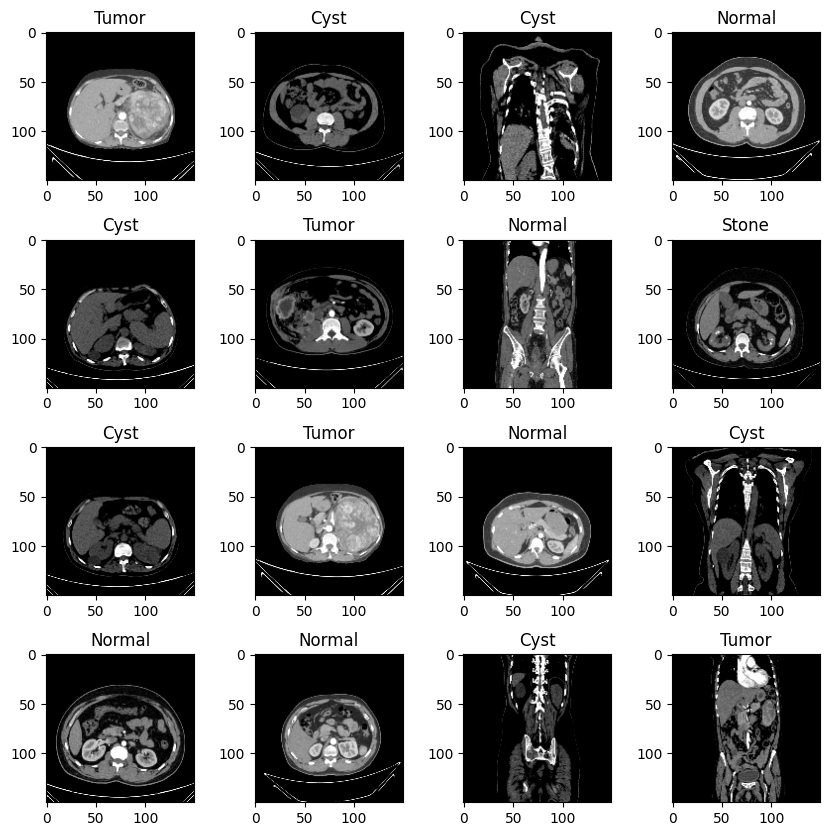

In [9]:
data_iterator = train.as_numpy_iterator()
batch = data_iterator.next()
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))
for i in range(4):  
    for j in range(4):  
        index = i * 4 + j  
        ax[i, j].imshow(batch[0][index].astype(int))
        ax[i, j].set_title(label_to_class_name[batch[1][index]])
plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()

# Preprocessing the data 

In [10]:
train=train.map(lambda x,y:(x/255,y))
val=val.map(lambda x,y:(x/255,y))

In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train = train.cache().prefetch(buffer_size=AUTOTUNE)
val = val.cache().prefetch(buffer_size=AUTOTUNE)

In [13]:
kernel = np.ones((3, 3), np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations = 2)

# sure background area
sure_bg = cv2.dilate(opening, kernel, iterations = 3)

# sure foreground area
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)

# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

# Displaying the connected components are foreground and background

# Building the model

In [20]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(4, activation=tf.nn.softmax)
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 32)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 41472)             0         
                                                                 
 dense (Dense)               (None, 128)               5

# Training the model

In [21]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])


In [22]:
epochs=10
history = model.fit(
  train,
  validation_data=val,
  epochs=epochs
)

Epoch 1/10
351/351 [==============================] - 100s 282ms/step - loss: 0.1098 - accuracy: 0.9622 - val_loss: 3.3682e-04 - val_accuracy: 1.0000
Epoch 2/10
351/351 [==============================] - 77s 218ms/step - loss: 1.5696e-04 - accuracy: 1.0000 - val_loss: 8.1095e-05 - val_accuracy: 1.0000
Epoch 3/10
351/351 [==============================] - 77s 220ms/step - loss: 5.2786e-05 - accuracy: 1.0000 - val_loss: 4.2244e-05 - val_accuracy: 1.0000
Epoch 4/10
351/351 [==============================] - 77s 219ms/step - loss: 2.8565e-05 - accuracy: 1.0000 - val_loss: 2.5830e-05 - val_accuracy: 1.0000
Epoch 5/10
351/351 [==============================] - 77s 219ms/step - loss: 1.7854e-05 - accuracy: 1.0000 - val_loss: 1.7256e-05 - val_accuracy: 1.0000
Epoch 6/10
351/351 [==============================] - 79s 225ms/step - loss: 1.2067e-05 - accuracy: 1.0000 - val_loss: 1.2161e-05 - val_accuracy: 1.0000
Epoch 7/10
351/351 [==============================] - 78s 221ms/step - loss: 8.5647e-

# Predicting the loss

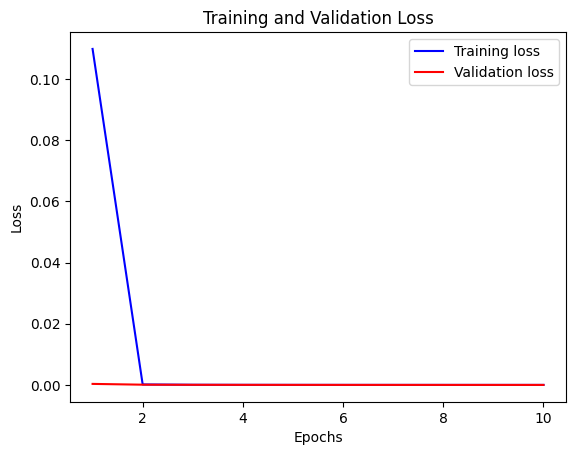

In [23]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting the accuracy

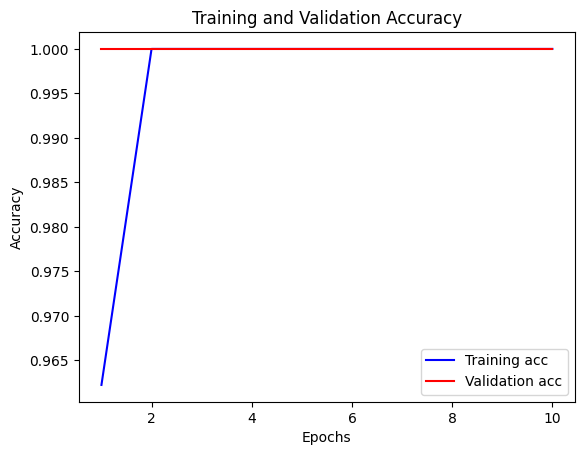

Accuracy of the model is: [0.9622389078140259, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
print("Accuracy of the model is:",acc)

# Predicting the output by accepting an input image

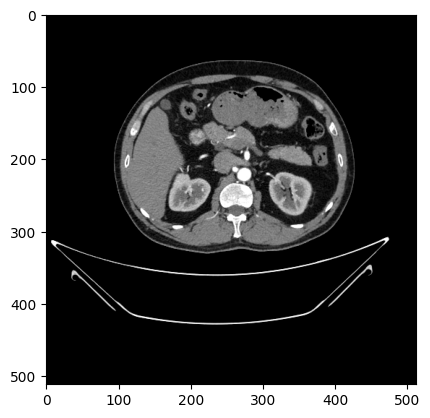

1/1 [==============================] - 0s 22ms/step


'Tumor'

In [26]:
#Giving an image with kidney tumor
img = cv2.imread(r"C:\Users\Desktop\MLIA\CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone\CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone\Tumor\Tumor- (3).jpg")
plt.imshow(img)
plt.show()
resize = tf.image.resize(img, (150,150))
yhat = model.predict(np.expand_dims(resize/255, 0))
max_index = np.argmax(yhat)
label_to_class_name[max_index]

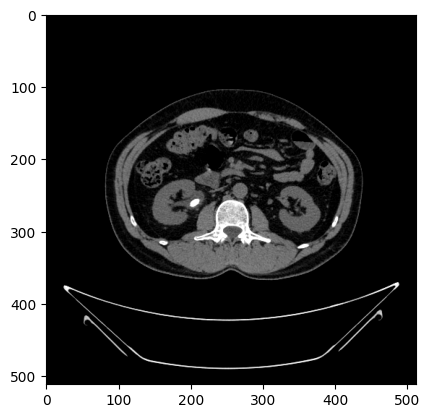

1/1 [==============================] - 0s 24ms/step


'Stone'

In [27]:
#Giving an image with kidney stone
img = cv2.imread(r"C:\Users\Desktop\MLIA\CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone\CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone\Stone\Stone- (12).jpg")
plt.imshow(img)
plt.show()
resize = tf.image.resize(img, (150,150))
yhat = model.predict(np.expand_dims(resize/255, 0))
max_index = np.argmax(yhat)
label_to_class_name[max_index]